In [58]:

import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, RepeatedKFold, LeaveOneOut
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_predict
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import os
import sys
from scipy.stats import linregress

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# Add project root to path (for Jupyter notebooks)
# Get the current directory and navigate to project root
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.insert(0, project_root)

from src.config import Config
import src.eda as eda
import src.present_value as present_value
from src.ml_utils import remove_outliers

%load_ext autoreload
%autoreload 2
%reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
## FROM DATABASE
pv = present_value.PresentValue()
anual_increment = pv.fetch_incremento_from_database()

fase = "III"
preproccesing = eda.EDA()
df_raw = preproccesing.assemble_projects_from_database(fase)
df_vp = preproccesing.create_dataset(pv.present_value_costs, fase=fase)

c:\Code\Road-Project-Prediction\src\eda.py:292: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = (df[cols] / totals).fillna(0)


In [65]:
df = df_vp.loc[:, 'CÓDIGO':'ALCANCE'].join(df_vp.loc[:, ['4 - SUELOS']])
df_grouped = df.groupby('CÓDIGO').agg({
    'ALCANCE': 'first',
    'PUENTES VEHICULARES UND': 'sum',
    'PUENTES VEHICULARES M2': 'sum',
    'PUENTES PEATONALES UND': 'sum',
    '4 - SUELOS': 'sum'
}).reset_index()
puentes_cols = ['PUENTES VEHICULARES UND', 'PUENTES VEHICULARES M2', 'PUENTES PEATONALES UND']
df_filtered = df_grouped[(df_grouped[puentes_cols].sum(axis=1) > 0) & (df_grouped['4 - SUELOS'] > 0)]
df_filtered = df_filtered[df_filtered['CÓDIGO']!='0654801']
df_clean = remove_outliers(df_filtered, '4 - SUELOS', contamination=0.1)
df_clean

  → Warning: Only 7 samples. Skipping outlier detection.


,CÓDIGO,ALCANCE,PUENTES VEHICULARES UND,PUENTES VEHICULARES M2,PUENTES PEATONALES UND,4 - SUELOS
0,0001,Segunda calzada,11,4856,14,1.878437e+08
3,0266702,Mejoramiento,0,0,1,1.326106e+07
5,0300605,Segunda calzada,13,16654,0,1.308015e+08
7,0347801,Rehabilitación,26,51069,0,8.669950e+08
9,0552903,Mejoramiento,6,3837,0,6.696069e+07
10,0581301,Mejoramiento,2,38,0,4.285348e+07
12,6935,Segunda calzada,4,6292,1,1.029912e+08


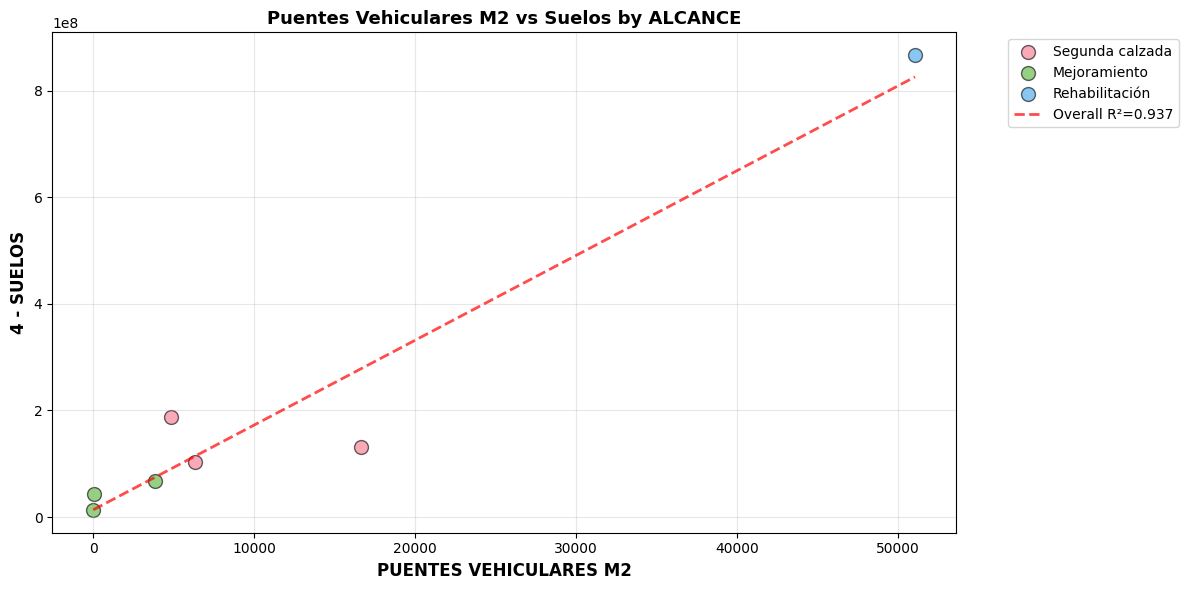

In [62]:
# Scatter plot with ALCANCE as hue
fig, ax = plt.subplots(figsize=(12, 6))

# Get unique ALCANCE values and assign colors
alcances = df_filtered['ALCANCE'].unique()
color_palette = sns.color_palette("husl", len(alcances))
color_map = dict(zip(alcances, color_palette))

# Plot each ALCANCE category separately
for alcance in alcances:
    mask = df_filtered['ALCANCE'] == alcance
    df_alcance = df_filtered[mask]
    
    ax.scatter(df_alcance['PUENTES VEHICULARES M2'], 
               df_alcance['4 - SUELOS'],
               alpha=0.6, s=100, 
               color=color_map[alcance],
               edgecolors='black', 
               linewidth=1,
               label=alcance)

# Overall regression line
slope, intercept, r_value, p_value, _ = linregress(df_filtered['PUENTES VEHICULARES M2'], 
                                                     df_filtered['4 - SUELOS'])
x_line = np.linspace(df_filtered['PUENTES VEHICULARES M2'].min(), 
                     df_filtered['PUENTES VEHICULARES M2'].max(), 100)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, 'r--', linewidth=2, alpha=0.7, label=f'Overall R²={r_value**2:.3f}')

# Labels and title
ax.set_xlabel('PUENTES VEHICULARES M2', fontsize=12, fontweight='bold')
ax.set_ylabel('4 - SUELOS', fontsize=12, fontweight='bold')
ax.set_title('Puentes Vehiculares M2 vs Suelos by ALCANCE', fontsize=13, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [63]:
# Function to calculate comprehensive metrics
def calculate_metrics(y_true, y_pred, model_name="Model"):
    """Calculate and return comprehensive regression metrics"""
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Additional metrics
    median_ae = np.median(np.abs(y_true - y_pred))
    max_error = np.max(np.abs(y_true - y_pred))
    
    return {
        'Model': model_name,
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'Median AE': median_ae,
        'Max Error': max_error
    }


## 2. Log Transformation of Target (y)


In [64]:
# LOG(y) Transformation
print("=" * 70)
print("Log(y) Transformation")
print("=" * 70)

# Prepare data for advanced analysis
X_m2 = df_clean[['PUENTES VEHICULARES M2']].values.flatten()
y_suelos = df_clean['4 - SUELOS'].values

# Remove zeros to allow log transformation
mask_nonzero = (X_m2 > 0) & (y_suelos > 0)
X_m2_clean = X_m2[mask_nonzero]
y_clean = y_suelos[mask_nonzero]


loo = LeaveOneOut()
results = []

X_log_y = X_m2_clean.reshape(-1, 1)
y_log = np.log(y_clean)

# Using TransformedTargetRegressor for proper inverse transformation
model_log_y = TransformedTargetRegressor(
    regressor=Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ]),
    func=np.log,
    inverse_func=np.exp
)

# Manual LOO to handle transformation properly
y_pred_log_y = np.zeros_like(y_clean)
for train_idx, test_idx in loo.split(X_log_y):
    X_train, X_test = X_log_y[train_idx], X_log_y[test_idx]
    y_train, y_test = y_clean[train_idx], y_clean[test_idx]
    
    model_log_y.fit(X_train, y_train)
    y_pred_log_y[test_idx] = model_log_y.predict(X_test)

metrics_log_y = calculate_metrics(y_clean, y_pred_log_y, "Log(y) Transform")
results.append(metrics_log_y)

print(f"R²:         {metrics_log_y['R²']:.4f}")
print(f"RMSE:       {metrics_log_y['RMSE']:.2f}")
print(f"MAPE:       {metrics_log_y['MAPE (%)']:.2f}%")
print()


Log(y) Transformation
R²:         0.9307
RMSE:       75610324.78
MAPE:       39.00%



In [81]:
df = df_vp.loc[:, 'CÓDIGO':'ALCANCE'].join(df_vp.loc[:, ['8 - ESTRUCTURAS']])
df_grouped = df.groupby('CÓDIGO').agg({
    'ALCANCE': 'first',
    'PUENTES VEHICULARES UND': 'sum',
    'PUENTES VEHICULARES M2': 'sum',
    'PUENTES PEATONALES UND': 'sum',
    '8 - ESTRUCTURAS': 'sum'
}).reset_index()
puentes_cols = ['PUENTES VEHICULARES UND', 'PUENTES VEHICULARES M2', 'PUENTES PEATONALES UND']
df_filtered = df_grouped[(df_grouped[puentes_cols].sum(axis=1) > 0) & (df_grouped['8 - ESTRUCTURAS'] > 0)]
df_filtered = df_filtered[df_filtered['CÓDIGO']!='0654801']
df_clean = remove_outliers(df_filtered, '8 - ESTRUCTURAS', contamination=0.1)
df_clean

  → Warning: Only 6 samples. Skipping outlier detection.


,CÓDIGO,ALCANCE,PUENTES VEHICULARES UND,PUENTES VEHICULARES M2,PUENTES PEATONALES UND,8 - ESTRUCTURAS
0,0001,Segunda calzada,11,4856,14,6.838215e+08
3,0266702,Mejoramiento,0,0,1,6.421774e+05
7,0347801,Rehabilitación,26,51069,0,1.345857e+09
9,0552903,Mejoramiento,6,3837,0,2.169088e+08
10,0581301,Mejoramiento,2,38,0,2.649237e+08
12,6935,Segunda calzada,4,6292,1,3.619036e+08


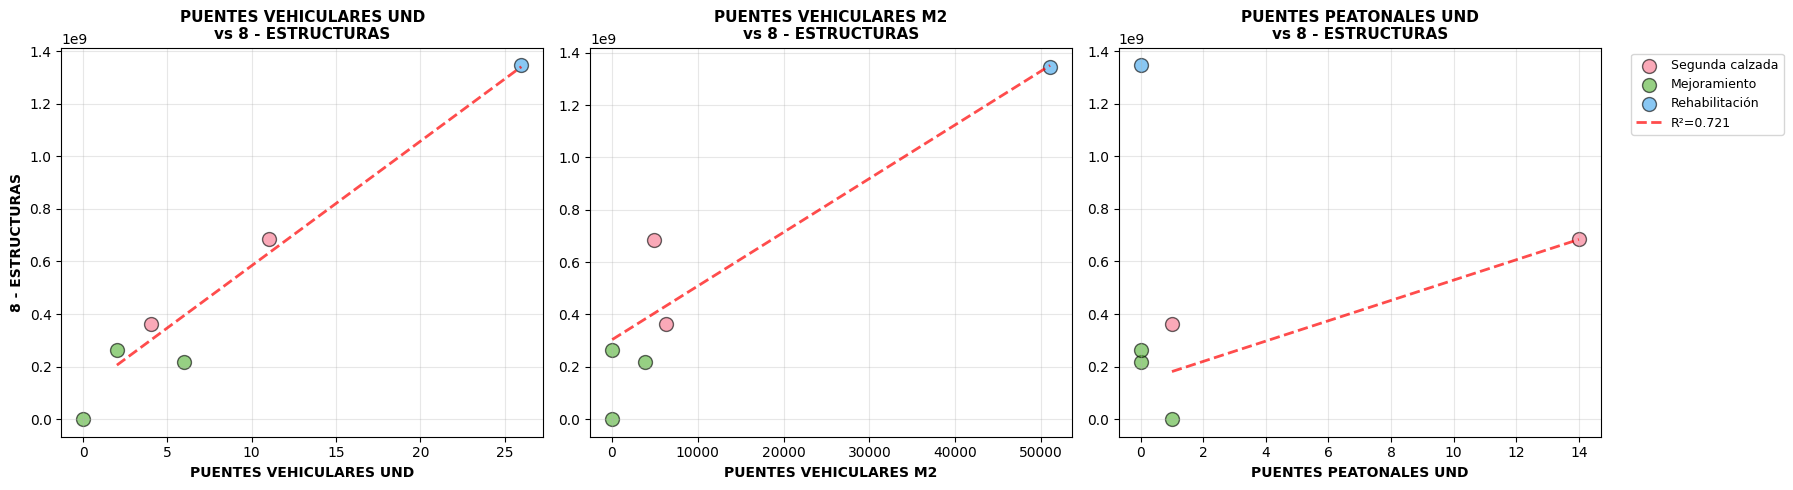


METRICS: Bridge Variables vs 8 - ESTRUCTURAS
               Variable       R²          MAE         RMSE    MAPE (%)  N
PUENTES VEHICULARES UND 0.952325 7.121231e+07 9.138479e+07   25.890602  5
 PUENTES VEHICULARES M2 0.871334 1.122962e+08 1.501278e+08   30.401356  5
 PUENTES PEATONALES UND 0.720685 1.204205e+08 1.474844e+08 9392.587590  3


In [83]:
# Visualization: Correlation between ALCANCE, Bridge Variables, and 8 - ESTRUCTURAS
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Get unique ALCANCE values and assign colors
alcances = df_filtered['ALCANCE'].unique()
color_palette = sns.color_palette("husl", len(alcances))
color_map = dict(zip(alcances, color_palette))

# Define the three bridge variables to plot
bridge_vars = ['PUENTES VEHICULARES UND', 'PUENTES VEHICULARES M2', 'PUENTES PEATONALES UND']
target = '8 - ESTRUCTURAS'

# Store metrics for each variable
all_metrics = []

# Create a subplot for each bridge variable
for idx, bridge_var in enumerate(bridge_vars):
    ax = axes[idx]
    
    # Plot each ALCANCE category separately
    for alcance in alcances:
        mask = df_filtered['ALCANCE'] == alcance
        df_alcance = df_filtered[mask]
        
        ax.scatter(df_alcance[bridge_var], 
                   df_alcance[target],
                   alpha=0.6, s=100, 
                   color=color_map[alcance],
                   edgecolors='black', 
                   linewidth=1,
                   label=alcance)
    
    # Calculate metrics and add regression line if there's variation in x
    if df_filtered[bridge_var].std() > 0:
        # Filter out zeros for better regression
        mask_nonzero = df_filtered[bridge_var] > 0
        if mask_nonzero.sum() > 1:
            x_data = df_filtered[mask_nonzero][bridge_var].values
            y_data = df_filtered[mask_nonzero][target].values
            
            # Fit linear model and get predictions
            from sklearn.linear_model import LinearRegression
            model = LinearRegression()
            X_reshape = x_data.reshape(-1, 1)
            model.fit(X_reshape, y_data)
            y_pred = model.predict(X_reshape)
            
            # Calculate comprehensive metrics
            r2 = r2_score(y_data, y_pred)
            mae = mean_absolute_error(y_data, y_pred)
            rmse = np.sqrt(mean_squared_error(y_data, y_pred))
            mape = np.mean(np.abs((y_data - y_pred) / y_data)) * 100 if (y_data != 0).all() else np.nan
            
            # Store metrics
            all_metrics.append({
                'Variable': bridge_var,
                'R²': r2,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE (%)': mape,
                'N': len(y_data)
            })
            
            # Plot regression line
            x_line = np.linspace(x_data.min(), x_data.max(), 100)
            y_line = model.predict(x_line.reshape(-1, 1))
            ax.plot(x_line, y_line, 'r--', linewidth=2, alpha=0.7, 
                   label=f'R²={r2:.3f}')
    
    # Labels and styling
    ax.set_xlabel(bridge_var, fontsize=10, fontweight='bold')
    ax.set_ylabel(target if idx == 0 else '', fontsize=10, fontweight='bold')
    ax.set_title(f'{bridge_var}\nvs {target}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Only show legend on the last subplot
    if idx == 2:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

# Display metrics table
print("\n" + "=" * 90)
print(f"METRICS: Bridge Variables vs {target}")
print("=" * 90)
metrics_df = pd.DataFrame(all_metrics)
print(metrics_df.to_string(index=False))
print("=" * 90)


In [84]:
## Linear Regression: PUENTES VEHICULARES UND → 8 - ESTRUCTURAS
print("=" * 90)
print("LINEAR REGRESSION: PUENTES VEHICULARES UND → 8 - ESTRUCTURAS")
print("=" * 90)

# Prepare data
X_puentes = df_clean['PUENTES VEHICULARES UND'].values
y_estructuras = df_clean['8 - ESTRUCTURAS'].values

# Remove zeros to allow proper analysis and log transformation
mask_nonzero = (X_puentes > 0) & (y_estructuras > 0)
X_clean = X_puentes[mask_nonzero]
y_clean = y_estructuras[mask_nonzero]

print(f"\nDataset size: {len(X_clean)} samples (after removing zeros)")
print(f"X range: [{X_clean.min():.2f}, {X_clean.max():.2f}]")
print(f"y range: [{y_clean.min():.2e}, {y_clean.max():.2e}]")
print()

# Initialize Leave-One-Out
loo = LeaveOneOut()
results = []

# ============================================================================
# 1. LINEAR REGRESSION (No transformation)
# ============================================================================
print("-" * 90)
print("1. Linear Regression (No Transformation)")
print("-" * 90)

X_linear = X_clean.reshape(-1, 1)

model_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# LOO Cross-validation
y_pred_linear = np.zeros_like(y_clean)
for train_idx, test_idx in loo.split(X_linear):
    X_train, X_test = X_linear[train_idx], X_linear[test_idx]
    y_train, y_test = y_clean[train_idx], y_clean[test_idx]
    
    model_linear.fit(X_train, y_train)
    y_pred_linear[test_idx] = model_linear.predict(X_test)

metrics_linear = calculate_metrics(y_clean, y_pred_linear, "Linear (No Transform)")
results.append(metrics_linear)

print(f"R²:         {metrics_linear['R²']:.4f}")
print(f"MAE:        {metrics_linear['MAE']:.2f}")
print(f"RMSE:       {metrics_linear['RMSE']:.2f}")
print(f"MAPE:       {metrics_linear['MAPE (%)']:.2f}%")
print(f"Median AE:  {metrics_linear['Median AE']:.2f}")
print(f"Max Error:  {metrics_linear['Max Error']:.2f}")
print()

# ============================================================================
# 2. LINEAR REGRESSION with LOG(y) Transformation
# ============================================================================
print("-" * 90)
print("2. Linear Regression with Log(y) Transformation")
print("-" * 90)

X_log_y = X_clean.reshape(-1, 1)

# Using TransformedTargetRegressor for proper inverse transformation
model_log_y = TransformedTargetRegressor(
    regressor=Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ]),
    func=np.log,
    inverse_func=np.exp
)

# Manual LOO to handle transformation properly
y_pred_log_y = np.zeros_like(y_clean)
for train_idx, test_idx in loo.split(X_log_y):
    X_train, X_test = X_log_y[train_idx], X_log_y[test_idx]
    y_train, y_test = y_clean[train_idx], y_clean[test_idx]
    
    model_log_y.fit(X_train, y_train)
    y_pred_log_y[test_idx] = model_log_y.predict(X_test)

metrics_log_y = calculate_metrics(y_clean, y_pred_log_y, "Linear Log(y) Transform")
results.append(metrics_log_y)

print(f"R²:         {metrics_log_y['R²']:.4f}")
print(f"MAE:        {metrics_log_y['MAE']:.2f}")
print(f"RMSE:       {metrics_log_y['RMSE']:.2f}")
print(f"MAPE:       {metrics_log_y['MAPE (%)']:.2f}%")
print(f"Median AE:  {metrics_log_y['Median AE']:.2f}")
print(f"Max Error:  {metrics_log_y['Max Error']:.2f}")
print()

# ============================================================================
# Summary Comparison
# ============================================================================
print("=" * 90)
print("SUMMARY COMPARISON")
print("=" * 90)
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
print("=" * 90)

# Determine best model
best_model_idx = results_df['R²'].idxmax()
best_model = results_df.iloc[best_model_idx]['Model']
print(f"\n✓ Best Model (by R²): {best_model}")
print("=" * 90)


LINEAR REGRESSION: PUENTES VEHICULARES UND → 8 - ESTRUCTURAS

Dataset size: 5 samples (after removing zeros)
X range: [2.00, 26.00]
y range: [2.17e+08, 1.35e+09]

------------------------------------------------------------------------------------------
1. Linear Regression (No Transformation)
------------------------------------------------------------------------------------------
R²:         0.9112
MAE:        106072066.14
RMSE:       124728195.95
MAPE:       36.06%
Median AE:  86741275.29
Max Error:  233861419.75

------------------------------------------------------------------------------------------
2. Linear Regression with Log(y) Transformation
------------------------------------------------------------------------------------------
R²:         -0.6515
MAE:        333363335.87
RMSE:       537866787.46
MAPE:       46.07%
Median AE:  184090791.71
Max Error:  1163100592.06

SUMMARY COMPARISON
                  Model        R²          MAE         RMSE  MAPE (%)    Median AE    